In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn as skl
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import Perceptron

In [3]:
occupancy_df = pd.read_csv('datatraining.txt')
occupancy_df

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.250000,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.000000,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.500000,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.250000,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.500000,0.004757,1
...,...,...,...,...,...,...,...
8139,2015-02-10 09:29:00,21.05,36.0975,433.0,787.250000,0.005579,1
8140,2015-02-10 09:29:59,21.05,35.9950,433.0,789.500000,0.005563,1
8141,2015-02-10 09:30:59,21.10,36.0950,433.0,798.500000,0.005596,1
8142,2015-02-10 09:32:00,21.10,36.2600,433.0,820.333333,0.005621,1


##### 2. Удалите дубликаты строк в наборе данных; приведите размер набора данных до и после данной операции

In [5]:
occupancy_df[occupancy_df.duplicated(keep=False)]

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy


Дупликатов нет

##### 3. Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая)

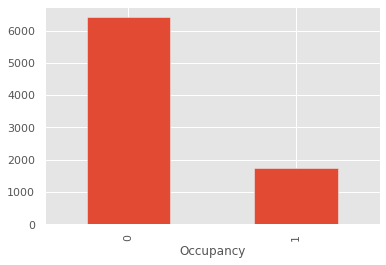

In [6]:
occupancy_df.groupby(["Occupancy"])["Occupancy"].count().plot(kind='bar')


##### 4. Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию)

In [8]:
numerical_columns = [i for i in occupancy_df.columns if occupancy_df[i].dtype.name != 'object' and occupancy_df[i].name != "Occupancy"]
print('numerical: ', numerical_columns)

numerical:  ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']


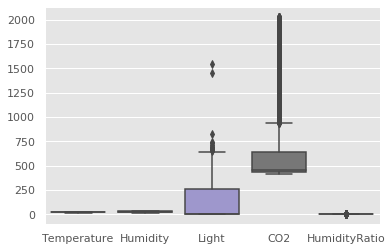

In [9]:
sns.boxplot(data=occupancy_df[numerical_columns])

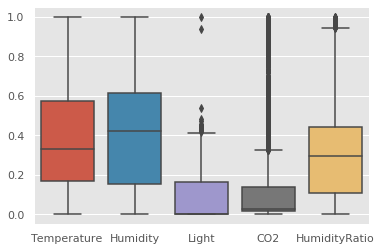

In [10]:
scaler = preprocessing.MinMaxScaler()
occupancy_df[numerical_columns] = scaler.fit_transform(occupancy_df[numerical_columns].values.astype(float))
sns.boxplot(data=occupancy_df[numerical_columns])
plt.show()

In [11]:
occupancy_df

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,1.000000,0.470533,0.275490,0.190933,0.557318,1
2,2015-02-04 17:51:59,0.992823,0.470332,0.277754,0.186446,0.554807,1
3,2015-02-04 17:53:00,0.992823,0.469326,0.275490,0.186136,0.553761,1
4,2015-02-04 17:54:00,0.992823,0.467315,0.275490,0.182887,0.551669,1
5,2015-02-04 17:55:00,0.980861,0.467315,0.275490,0.180566,0.547851,1
...,...,...,...,...,...,...,...
8139,2015-02-10 09:29:00,0.490431,0.865013,0.280017,0.231781,0.763986,1
8140,2015-02-10 09:29:59,0.490431,0.860431,0.280017,0.233173,0.759782,1
8141,2015-02-10 09:30:59,0.502392,0.864901,0.280017,0.238744,0.768438,1
8142,2015-02-10 09:32:00,0.502392,0.872276,0.280017,0.252256,0.775226,1


##### 6. Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации

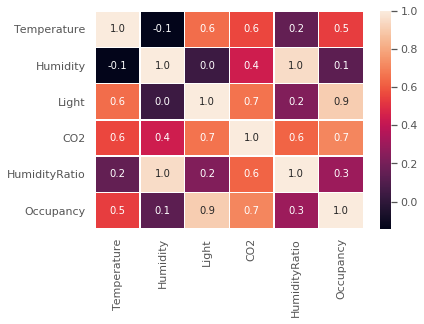

In [13]:
sns.heatmap(occupancy_df.corr(),annot = True, fmt = '.1f', linewidths = .5);

In [14]:
occupancy_df.drop(['HumidityRatio','date'], axis=1 ,inplace = True)

##### 7. Заполните пропущенные значения в данных;

In [15]:
occupancy_df.isna().sum()

Temperature    0
Humidity       0
Light          0
CO2            0
Occupancy      0
dtype: int64

Пропущенных данных нет

##### 8. Решите поставленную задачу классификации в соответствии с заданием. При подборе параметров классификатора используйте метод GridSearchCV и перекрёстную проверку (изучите возможные для изменения параметры классификации). Оцените качество работы классификатора.

In [26]:
X = occupancy_df.drop(('Occupancy'), axis=1)
y = occupancy_df['Occupancy']
feature_names = X.columns
print(feature_names)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 11)

Index(['Temperature', 'Humidity', 'Light', 'CO2'], dtype='object')


Классификатор K ближайших соседей (задаётся количество ближайших объектов)¶


In [20]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/neighbors/base.py:908: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [24]:
parameters = {'n_neighbors':[1,10,15]}
grid = GridSearchCV(knn,parameters)
grid = grid.fit(X_train,y_train)
K = grid.best_estimator_.n_neighbors
best = grid.best_score_
print('best: ', best, ', neighbors num: ', K, sep='')

knc = KNeighborsClassifier(n_neighbors = K)
knc.fit(x_train,y_train)
knc_predict = knc.predict(x_test)
print('Accuracy knn: %.5f' % accuracy_score(y_test, knc_predict))

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationW

best: 0.9933333333333333, neighbors num: 1
Accuracy knn: 0.99591


/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/neighbors/base.py:908: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, c

Линейный классификатор (персептрон)


In [27]:
ppn = Perceptron()
parameters_pnn = {'alpha': np.linspace(0, 1, 50)[1:]}
grid_ppn = GridSearchCV(ppn, parameters_pnn,cv = 3) 
grid_ppn.fit(X_train, y_train)
alpha = grid_ppn.best_estimator_.alpha
max_iter = grid_ppn.best_estimator_.max_iter

ppn = Perceptron(alpha = alpha, max_iter = max_iter)
ppn.fit(X_train, y_train)
y_score = ppn.predict(X_test)

print("accuracy:", accuracy_score(y_test, y_score))
print("best:", grid_ppn.best_score_)

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. I

accuracy: 0.986901350798199
best: 0.9438596491228071


/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to revie